# Phase 1 - Project 1
We are given 6 data sets. All data are from movies with some have similar information. 
We must first look through to see which dataset is useful and clean them up to make them usable
After which, we can make visuals that will support the claims while looking through the data. 

## Data Setup

### Data Imports
All libraries that may be required in the project

In [ ]:
import csv    #for the cvs and txv files
import sqlite3 as sql   #for the db file
import pandas as pd    #Help visualize the data
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

### Read All files
Sample the files to see the contents. Determine which is usable
for this project

In [ ]:
#Main use, pull best and worst genre based on rating
df_1 = pd.read_csv("data/tmdb.movies.csv.gz")   
df_1.head()

In [ ]:
#Main use, productuon_budget, domestic gross, worldwide gross
df_2 = pd.read_csv("data/tn.movie_budgets.csv.gz")
df_2.head()

In [ ]:
#https://docs.python.org/3/library/codecs.html#standard-encodings - Helped with finding valid encoding
df_3 = pd.read_csv('data/rt.reviews.tsv.gz',delimiter = '\t', encoding = 'cp437' )
df_3.head()

In [ ]:
df_4 = pd.read_csv('data/rt.movie_info.tsv.gz',delimiter = '\t')
df_4.head()

In [ ]:
#Main use, studio, could use to double check df1
df_5 = pd.read_csv('data/bom.movie_gross.csv.gz',delimiter = '\t')
df_5.head()

In [ ]:
#SQL connection with movie ratings and director name
conn = sql.connect('data/im.db/im.db')

In [ ]:
#Look at the data
pd.read_sql("""SELECT * FROM persons""", conn)

Conclusion: Both The Numbers and Box Office Mojo have similar dataset. Will The The Numbers for consistancy purposes
            Rotten Tomatoes and IMDB have data with NaN values which will not be usable for those given columns

## Data Exploration

### The Movie DB 
Useful keys: Popularity, vote count, vote average

In [ ]:
print(df_1.columns)
df_1['genre_ids']    #What does these numbers mean? - 
df_1['id']    #Each movie has a unique id
df_1['original_language']    #Only english movies? - No, there are multiples
df_1['original_title']     #Title of the movie - Use title for consistency
df_1['popularity']    #Ranking out of ... 100 , Website looks like percentage - based on amount timed watched?
df_1.sort_values('popularity').tail()
#Release data, title are pretty obvious, may need to look in title vs original title
df_1.loc[df_1['vote_average'] == 0]  #Quite a few with not votes and therefore no vote average

### The Number
Useful Keys: Production Budget, Domestic Budget, Worldwide Budget

In [ ]:
df_2.duplicated().sum()    #No dups?
df_2.isna().sum()    #No NaN
df_2.isnull().sum()    #No Null
df_2.info()    #All usable except release data right now

### Rotten Tomatoes
Useful keys: Freshness, critic, top critic and publisher - May not be used
Data has too many missing and NaN values to be used at its current state.
Will Opt to not use this dataset

In [ ]:
# Rotten Tomatoes review info
df_3.head()
df_3.info() 
df_3.isna().sum()    #1/4 of ratings are NaN - may not be too useful
df_3.loc[df_3['review'].isna()]    #Review are just the written words - Okay to be NaN for our case
df3_top_critic = df_3.loc[df_3['top_critic'] == 1]    #1/4 of reviews are made from 'top critics' - Could be useful for creditabilty
#print(len(df3_top_critic['critic'].unique()))    #856 unique critics    
#print(len(df3_top_critic))    #13096 review from top critics

In [ ]:
# Rotten Tomatoes movie info
df_4.head()
df_4.sort_values('box_office')    #Not alot of info like the other data set
df_4.isna().sum()    #1560 entires, 1220 are NaN. Data set not usable for current project.
df_4.info()

### IMDB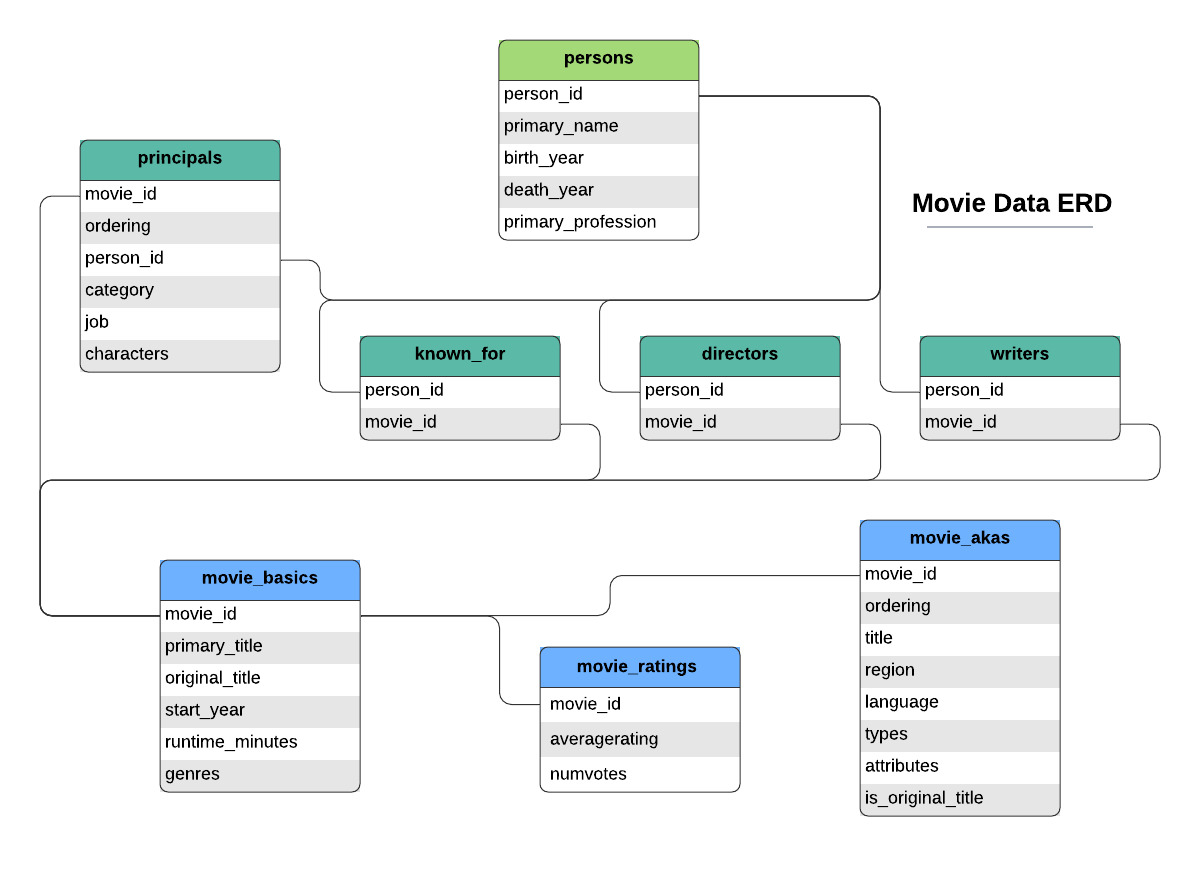

In [ ]:
### Sort the directors by average rating and number of number
pd.read_sql("""SELECT  persons.primary_name AS 'Director Name' , AVG(averagerating) AS 'Average Rating', COUNT(movie_id) AS 'Number of Movies'
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)

GROUP BY persons.primary_name
ORDER BY AVG(averagerating) DESC
""", conn)
### We only care about high rated movies and directors with at least above average of movies ###

### Conclusion
All the dataset are usable other than the Rotten Tomatoes datasets.
We will be using the genre and popularity of the The Movie DB, the budget and gross profit of The Numbers, and the movie director info from IMBD. 
Some cleaning and filtering will be needed to make the data ready for analysis

## Data Preperation
Prepare the data for plotting and analysis

### The Moive DB
Dropping Unnamed column and remove duplicate

In [ ]:
####   Data Cleaning    ###
print(df_1.info())    #Unknown column
df_1['Unnamed: 0']    #No use, index column
df_1.drop("Unnamed: 0", axis = 1, inplace= True)   #Remove the column
df_1.columns    #Confirm the drop

In [ ]:
###    Check missing values    ###
print (df_1.isna().sum())    #No NaN values
print (df_1.isnull().sum())    #No Null Values

In [ ]:
###    Remove dups    ###
df_1.duplicated().sum()    #There are duplicated movies? Multiple languages?
df_1[df_1.duplicated(keep = False)].sort_values(by = 'id')    #Looks like straight copies - Need to remove
df_1.drop_duplicates(inplace = True)    #Remove dups
df_1.duplicated().sum()   #Check again for dups

In [ ]:
#Sort by popularity to see whats type of movies are the best
df_1.sort_values('popularity', inplace = True,ascending= False)    #Only care about the most popular movies
df_1['genre_ids'] = ((df_1['genre_ids'].map(lambda x: x.strip('[]'))).map(lambda x: x.replace(' ', ''))).map(lambda x: x.split(','))    #Strip and normalize the genre id list
df1_top_movies = df_1[0:100]    #Top 100 movies 
df1_worst_movie = df_1[-100:]    #Worst 100 movies

In [ ]:
# Convert the genre id to names for understanding purposes
convert = {'28' : 'Action', '12': 'Adventure', '35': 'Comedy', '99': 'Documentary', 
           '18': 'Drama', '14': 'Fantasy', '27': 'Horror', '878' : 'Sci-Fi', '53' : 'Thriller',
           '16': 'Animation', '80' : 'Crime', '10751' : 'Family','14':'Fantasy',
           "36" : 'History','27': 'Horror', '10402':'Music', '9648':'Mystery',
           '10749':'Romance','10770': 'TV Movie','10752': 'War','37':'Western', '': "NULL" }

# Function count all the genre and group them
def count_genre(df_list):
    genre_count = {}    #https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee

    for genre in df_list['genre_ids']:    #Take the list of genre ids
        for ids in genre:    #For each element in the list, multiple genre for one movie
            if(genre_count.get(convert[ids])):    #Check if it exists,
                genre_count[convert[ids]] += 1    #Convert the ID and add 1 to counter
            else:
                genre_count[convert[ids]] = 1
    return sorted(genre_count.items(), key = lambda x: x[1], reverse=True)    #Return the list sorted by the most popular genre

Conclusion: Removed invalid columns and normalize the columns being sured. Convert Genre Id for better visuals while not being necessary makes anaylising easier

### The Number
Nothing to removed. Budget and Gross Income are changed for statistical purposes

In [ ]:
###    Change the columns to integer for comparing and statistical methods    ###
df_2['production_budget'] = df_2['production_budget'].map(lambda x: x.strip('$'))    #Take out the $
df_2['production_budget'] = df_2['production_budget'].map(lambda x: x.replace(',',''))    #Remove the , 
df_2['production_budget'] = df_2['production_budget'].astype('int64')    #Convert to int64

df_2['domestic_gross'] = df_2['domestic_gross'].map(lambda x: x.strip('$'))    #Take out the $
df_2['domestic_gross'] = df_2['domestic_gross'].map(lambda x: x.replace(',',''))    #Remove the , 
df_2['domestic_gross'] = df_2['domestic_gross'].astype('int64')

df_2['worldwide_gross'] = df_2['worldwide_gross'].map(lambda x: x.strip('$'))   #Take out the $
df_2['worldwide_gross'] = df_2['worldwide_gross'].map(lambda x: x.replace(',',''))    #Remove the , 
df_2['worldwide_gross'] = df_2['worldwide_gross'].astype('int64')

In [ ]:
###   Make the ratio for both the profit
df_2['prod_dom_ratio'] = df_2['domestic_gross'] / df_2['production_budget']    #Ratio on the more proftitable movie - Domestic
df_2['prod_world_ratio'] = df_2['worldwide_gross'] / df_2['production_budget']    #Ratio on the more proftitable movie - worldwide
df_2.head(10)     #One outlier...I see
###   Domestic to Budget    ###
df_2.sort_values(['prod_dom_ratio'], ascending= False, inplace= True)    
print((df_2['prod_dom_ratio'] > 1).sum())    #Half the movie broke even - Categorical?
print((df_2['prod_dom_ratio'] > 2).sum())    #1/4 of the movie doubled <- Goal
print((df_2['prod_dom_ratio'] > 3).sum())    #Best case for most movies 
###   World to Budget    ###
df_2.sort_values(['worldwide_gross'], ascending= False, inplace= True)
print((df_2['prod_world_ratio'] > 1).sum()) 
print((df_2['prod_world_ratio'] > 2).sum())
print((df_2['prod_world_ratio'] > 3).sum())   
###    Production vs Domestic Ratio    ###
df_2.sort_values(['prod_dom_ratio'], ascending= False, inplace= True)
df2_most_prof = df_2['movie'].loc[df_2['prod_dom_ratio'] > 1]
df2_most_prof_2 = df_2['movie'].loc[df_2['prod_dom_ratio'] > 2]
df2_most_prof_3 = df_2['movie'].loc[df_2['prod_dom_ratio'] > 3] 
###    Production vs WorldWide Ratio    ###
df_2.sort_values(['prod_world_ratio'], ascending= False, inplace= True)
df2_most_prof_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 1]  
df2_most_prof_2_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 2]  
df2_most_prof_3_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 3]  



#### Categorical Data
Make the ratio into categories to see if that is easier to interpret

In [ ]:
def cat_ratio (ratio):
    if ratio < 1:    #Less than 1 is a 0 - negative profit
        return 0
    elif ratio < 2:    #Between 1 and 2
        return 1
    elif ratio < 3:    #Between 2 and 3
        return 2
    else:   #Greater than 3
        return 3    
df_2['cat_f'] = df_2['prod_world_ratio'].map(lambda x: cat_ratio(x))

In [ ]:
#df_2['cat_f'].plot.hist()
zero_cat = len(df_2.loc[df_2['cat_f'] == 0])
one_cat = len(df_2.loc[df_2['cat_f'] == 1])
two_cat = len(df_2.loc[df_2['cat_f'] == 2])
three_cat = len(df_2.loc[df_2['cat_f'] == 3])
print("""
{:.0%} have a ratio of less than 1
{:.0%} have a ratio of 1 to 2
{:.0%} have a ratio of 2 to 3
{:.0%} have a ratio of more than 3
""".format(zero_cat/5782, one_cat/5782, two_cat/5782, three_cat/5782))

### Too screwed due to outliers?
print('Average production budget with ratio less than 1: ', df_2['production_budget'].loc[df_2['cat_f'] == 0].mean())
print('Average production budget with ratio between 1 and 2: ', df_2['production_budget'].loc[df_2['cat_f'] == 1].mean())
print('Average production budget with ratio between 2 and 3: ', df_2['production_budget'].loc[df_2['cat_f'] == 2].mean())
print('Average production budget with ratio over 3: ', df_2['production_budget'].loc[df_2['cat_f'] == 3].mean())


In [ ]:
df_2['production_budget'].std()
IQR = df_2['production_budget'].quantile(.75) - df_2['production_budget'].quantile(.25)
min_out = df_2['production_budget'].median() - IQR*1.5
max_out = df_2['production_budget'].median() + IQR*1.5
print(max_out)
outlier_removed = df_2.loc[df_2['production_budget'] < max_out]
outlier_removed['production_budget'].std()

In [ ]:
print('Average production budget with ratio less than 1: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 0].mean())
print('Average production budget with ratio between 1 and 2: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 1].mean())
print('Average production budget with ratio between 2 and 3: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 2].mean())
print('Average production budget with ratio over 3: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 3].mean())


In [ ]:
outlier_removed['production_budget'].plot.box()

#### The Movie DB and The Number
Combine the two dataset to see the correlation between the genre and the most profitable movies

In [ ]:
# Titles from the first dataset
df1_top_list = list(df1_top_movies['title'])    #Top 100 movies from the first dataset
   
df1_top_genre = count_genre(df1_top_movies)    #Top genre from the most popular movies
df1_worst_genre = count_genre(df1_worst_movie)    #Top genre from teh worst movies

###    Function that takes the data frame, takes the movie name if they are also in the top movie list    ###
def list_of_movies(df_list):
    movie_list = []    #Make a empty list
    for name in df_list:    #For each movie in the list    
        for top in df1_top_list:    #Check if any of the most popular list are in the second list
            if(name == top):    #If match
                movie_list.append(name)     #Add the list
    return movie_list      


In [ ]:
###    Over_# is the list of genre based on the movies with the respective ratios
###    If the movie is also in the most profitable list and the most popular list,
###    they count the genre for that ratio
over_1 = count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof))])
over_2 = count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_2))])
over_3 = count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_3))])

over_1_w = count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_world))])
over_2_w = count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_2_world))])
over_3_w = count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_3_world))])

all_genre = count_genre(df_1)

In [ ]:
movie_less_1_n_med = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] < 20000000.0)])
movie_less_1= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] < 20000000.0)])
movie_more_1_n_med = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] > 20000000.0)])
movie_more_1= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] > 20000000.0)])

movie_less_1_n_42 = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] < 42000000.0)])
movie_less_1_42= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] < 42000000.0)])
movie_more_1_n_42 = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] > 42000000.0)])
movie_more_1_42= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] > 42000000.0)])

world_movie_under_1 = len(df_2['movie'].loc[df_2['prod_world_ratio'] <= 1])
world_movie_over_1 = len(df2_most_prof_world)

In [ ]:
print("Highest Worldwide Grossing movies all have higher than 3 ratio?", over_1_w == over_2_w == over_3_w)
print("""Number of movies with a ratio of 1 and above? 
      Domestic: {}, Foreign: {} """.format(len(df2_most_prof),len(df2_most_prof_world)))
print("""Number of movies with a ratio of 2 and above? 
      Domestic: {}, Foreign: {} """.format(len(df2_most_prof_2),len(df2_most_prof_2_world)))
print("""Number of movies with a ratio of 3 and above? 
      Domestic: {}, Foreign: {} """.format(len(df2_most_prof_3),len(df2_most_prof_3_world)))
print("""Number of movies with a ratio of under 1? 
      Domestic: {}, Foreign: {} """.format(len(df_2['movie'].loc[df_2['prod_dom_ratio'] <= 1]),world_movie_under_1))
print("""
{} movies out of {} have a ratio of < 1 with a budget less than 20000000
{} movies out of {} have a ratio of < 1 with a budget less than 42000000
{} movies out of {} have a ratio of < 1 with a budget more than 42000000
""".format(movie_less_1_n_med, world_movie_under_1,movie_less_1_n_42,world_movie_under_1,movie_more_1_n_42, world_movie_under_1 ))
print("""
{} movies out of {} have a ratio of > 1 with a budget less than 20000000
{} movies out of {} have a ratio of > 1 with a budget less than 42000000
{} movies out of {} have a ratio of > 1 with a budget more than 42000000
""".format(movie_less_1, world_movie_over_1,movie_less_1_42,world_movie_over_1,movie_more_1_42, world_movie_over_1 ))
print("""
{} movies out of {} have a ratio of > 1 with a budget more than 20000000

""".format(movie_more_1,len(df2_most_prof_world)))

In [ ]:
#Determine a reasonable range of budget that gives the most benifical ratio possible
df_2.sort_values(['production_budget'], ascending= False, inplace= True)
IQR = df_2['prod_world_ratio'].quantile(.75) - df_2['prod_world_ratio'].quantile(.25)
min_out = df_2['prod_world_ratio'].median() - IQR*1.5
max_out = df_2['prod_world_ratio'].median() + IQR*1.5

outlier_removed = df_2.loc[df_2['prod_world_ratio'] < 6.607385548232989]
outlier_removed['prod_world_ratio'].describe()
scat_x = outlier_removed['production_budget'].loc[outlier_removed['prod_world_ratio'] > 1]
scat_y = outlier_removed['prod_dom_ratio'].loc[outlier_removed['prod_world_ratio'] > 1]
outlier_removed['prod_world_ratio'].median()
outlier_removed['production_budget'].quantile(.75)

### IMDB
Database that has alot of information so will be only focusing on director

In [ ]:
pd.read_sql("""SELECT persons.primary_name AS 'Director Name', COUNT(movie_id) AS 'Number of Movies'
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)
GROUP BY persons.primary_name
""", conn)

181387 movies
73103 movies group by movie Id
57241 movie group by person id

In [ ]:
### Find Average ratings for all the movies - 6.22
pd.read_sql("""SELECT AVG(averagerating) AS 'Average Rating'
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)
""", conn)

In [ ]:
pd.read_sql("""
SELECT AVG(NumberofMovies)
FROM (
    SELECT COUNT(movie_id) AS NumberofMovies
    FROM movie_ratings
    JOIN movie_basics
        USING (movie_id)
    JOIN directors
        USING (movie_id)
    JOIN persons
        USING (person_id)
    GROUP BY persons.primary_name
    HAVING NumberofMovies > 1
    )
    
""", conn)

In [ ]:
pd.read_sql("""SELECT persons.primary_name, COUNT(movie_id), AVG(averagerating)
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)
GROUP BY persons.primary_name
HAVING AVG(averagerating) > 6.332729 AND COUNT(movie_id) > 4
ORDER BY AVG(averagerating) DESC
""", conn)

In [ ]:
list_of_directors= pd.read_sql("""SELECT primary_title, persons.primary_name, COUNT(movie_id), AVG(averagerating)
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)
GROUP BY primary_title
HAVING AVG(averagerating) > 6.332729 AND COUNT(movie_id) > 5

ORDER BY AVG(averagerating) DESC
""", conn)

In [ ]:
list(list_of_directors['primary_title'])

In [ ]:
best_dir_movies = []
for movie in list(list_of_directors['primary_title']):
    if movie in df1_top_list:
        best_dir_movies.append(movie)
best_dir_movies

In [ ]:
Recommended_dir = pd.read_sql("""SELECT primary_title AS 'Movie Title'
                ,persons.primary_name AS 'Director Name'
                , COUNT(movie_id) AS 'Number of Movies' 
                ,AVG(averagerating) AS 'Average Movie Ratings'
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)
WHERE primary_title IN ('Spider-Man: Into the Spider-Verse','Avengers: Infinity War','How to Train Your Dragon','Guardians of the Galaxy','Zootopia',
                        'Thor: Ragnarok','A Star Is Born','Captain America: Civil War','Big Hero 6', 'Guardians of the Galaxy Vol. 2',
                        'Spider-Man: Homecoming','Ant-Man','Iron Man 3','Aquaman','Ant-Man and the Wasp','Logan','Ralph Breaks the Internet',
                        'X-Men: Apocalypse','Thor','Thor: The Dark World','Beauty and the Beast','Kong: Skull Island','Pirates of the Caribbean: Dead Men Tell No Tales',
                        'Justice League','Batman v Superman: Dawn of Justice','The Mule')
GROUP BY primary_title
HAVING AVG(averagerating) > 6.332729 AND COUNT(movie_id) > 5

ORDER BY AVG(averagerating) DESC
LIMIT 10
""", conn)

In [ ]:
set(Recommended_dir['Director Name'])

In [ ]:
Recommended_dir

## Data Visualization

### Best and Worst Movie Genre

In [ ]:
x, y = zip(*df1_top_genre)    #Seperate the tuple into movie and count
x2,y2 = zip(*df1_worst_genre)

fig, ax = plt.subplots(1,2, figsize = (20,10))
colors1 = ['red' if genre in x2[0:5] else 'green' for genre in x]    #Red for genre in the worst genre list
colors2 = ['cyan' if genre in x[0:5] else 'black' for genre in x2]    #Cyan for genre in the top genre list

ax[0].barh(x,y, color = colors1);
ax[0].set_xlabel("Frequency");
ax[0].set_ylabel("Genre");
ax[0].set_title("Best Genre from Top 100 Movies");
ax[0].legend(["Good Tags"]);

ax[1].barh(x2,y2, color = colors2);
ax[1].set_xlabel("Frequency");
ax[1].set_ylabel("Genre");
ax[1].set_title("Worst Genre from Worst 100 Movies");
ax[1].legend(["Bad Tags"]);

In [ ]:
#Plot the most popular movie genre 
ax = plt.subplot()
x, y = zip(*all_genre)
ax.barh(x,y, color = 'red');
ax.set_title('Most Popular Genre - All Movies');
ax.set_xlabel('Frequency');
ax.set_ylabel('Genre');

### Most Profitable Genre 

#### Domestic

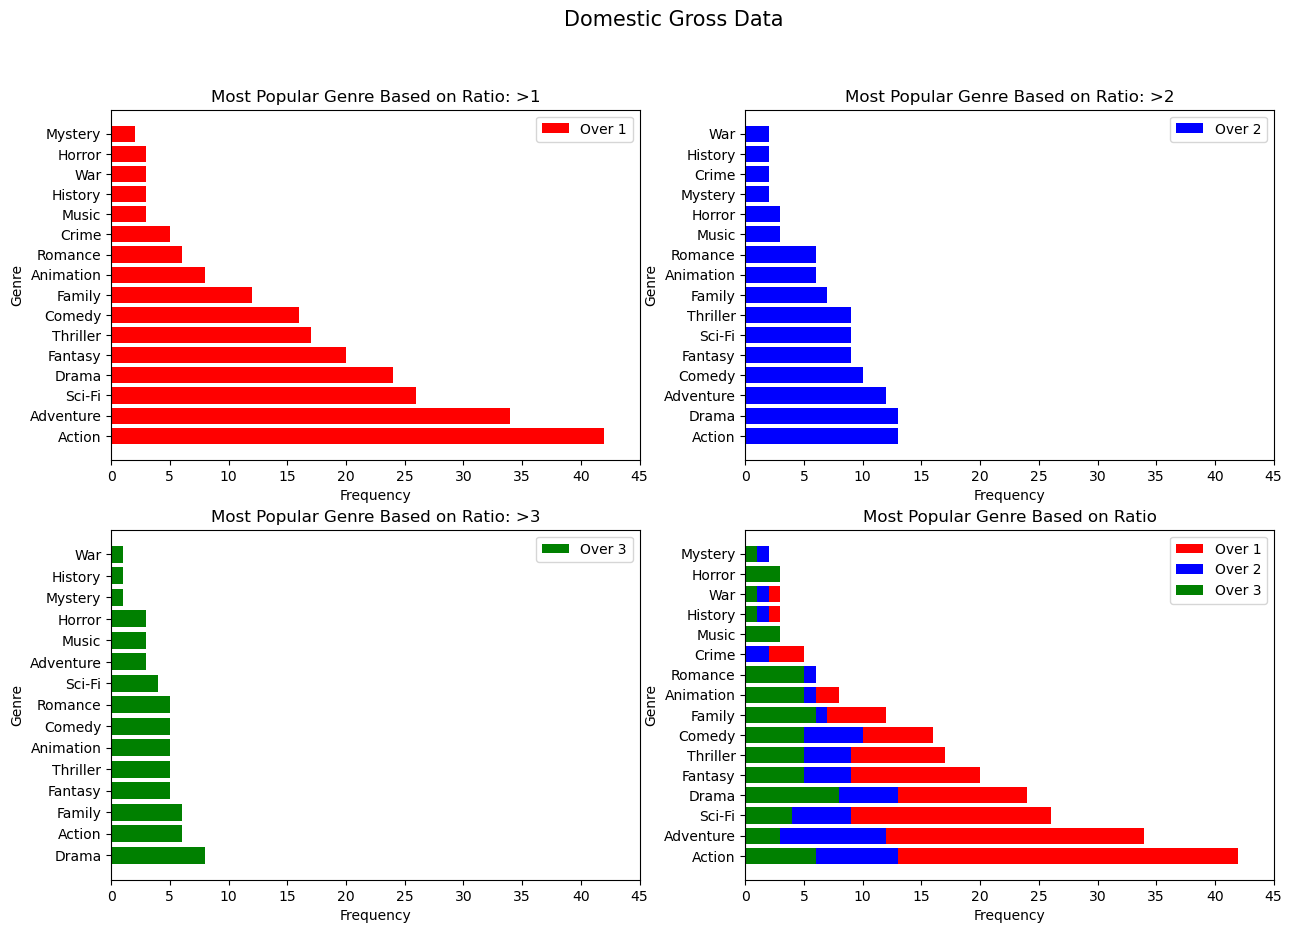

In [47]:
fig , ax = plt.subplots(2,2, figsize =(15, 10))
x, y = zip(*over_1)
x2, y2 = zip(*over_2)
x3, y3 = zip(*over_3)

fig.suptitle('Domestic Gross Data', fontsize=15)
ax[0,0].barh(x,y, color = 'red', label = 'Over 1')
ax[0,0].legend();
ax[0,0].set_title('Most Popular Genre Based on Ratio: >1');
ax[0,0].set_xlabel('Frequency')
ax[0,0].set_ylabel('Genre')
ax[0,0].set_xlim([0,45])

ax[0,1].barh(x2,y2, color = 'blue',label = 'Over 2')
ax[0,1].legend();
ax[0,1].set_title('Most Popular Genre Based on Ratio: >2');
ax[0,1].set_xlabel('Frequency')
ax[0,1].set_ylabel('Genre')
ax[0,1].set_xlim([0,45]);

ax[1,0].barh(x3,y3, color = 'green', label = 'Over 3')
ax[1,0].legend();
ax[1,0].set_title('Most Popular Genre Based on Ratio: >3');
ax[1,0].set_xlabel('Frequency')
ax[1,0].set_ylabel('Genre')
ax[1,0].set_xlim([0,45]);

ax[1,1].barh(x,y, color = 'red', label = 'Over 1');
ax[1,1].barh(x2,y2,  color = 'blue', label = 'Over 2');
ax[1,1].barh(x3,y3,  color = 'green', label = 'Over 3');
ax[1,1].legend();
ax[1,1].set_title('Most Popular Genre Based on Ratio');
ax[1,1].set_xlabel('Frequency')
ax[1,1].set_ylabel('Genre')
ax[1,1].set_xlim([0,45]);

#### International

In [ ]:
fig2 , ax2 = plt.subplots(2,2, figsize =(15, 10))
x4, y4 = zip(*over_1_w)
x5, y5 = zip(*over_2_w)
x6, y6 = zip(*over_3_w)

fig2.suptitle('Foreign Gross Data', fontsize=15)
ax2[0,0].barh(x4,y4, color = 'red', label = 'Over 1')
ax2[0,0].legend();
ax2[0,0].set_title('Most Popular Genre Based on Ratio: >1');
ax2[0,0].set_xlabel('Frequency')
ax2[0,0].set_ylabel('Genre')
ax2[0,0].set_xlim([0,60])

ax2[0,1].barh(x5,y5, color = 'blue',label = 'Over 2')
ax2[0,1].legend();
ax2[0,1].set_title('Most Popular Genre Based on Ratio: >2');
ax2[0,1].set_xlabel('Frequency')
ax2[0,1].set_ylabel('Genre')
ax2[0,1].set_xlim([0,60]);

ax2[1,0].barh(x6,y6, color = 'green', label = 'Over 3')
ax2[1,0].legend();
ax2[1,0].set_title('Most Popular Genre Based on Ratio: >3');
ax2[1,0].set_xlabel('Frequency')
ax2[1,0].set_ylabel('Genre')
ax2[1,0].set_xlim([0,60]);

ax2[1,1].barh(x4,y4, color = 'red', label = 'Over 1');
ax2[1,1].barh(x5,y5,  color = 'blue', label = 'Over 2');
ax2[1,1].barh(x6,y6,  color = 'green', label = 'Over 3');
ax2[1,1].legend();
ax2[1,1].set_title('Most Popular Genre Based on Ratio');
ax2[1,1].set_xlim([0,60]);

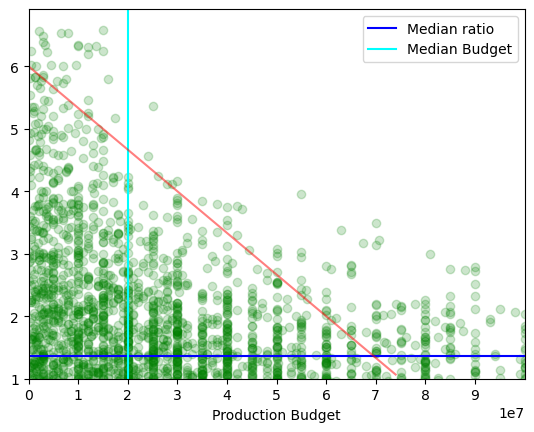

In [48]:
fig, ax = plt.subplots()
ax.scatter(scat_x, scat_y , alpha= .2, color = 'green')
#line = plt.axvline(200000000, color = 'red');
ax.set_xlabel('Production Budget')
ax.set_xticks(list(range(0,100000000,10000000)));

#ax.set_xticks([0,10000000,20000000]);
ax.set_xlim(0,100000000)
ax.set_ylim(1)
x = list(range(0,74000000,1000))
y = [6-x2/15000000 for x2 in x]
ax.axhline(outlier_removed['prod_world_ratio'].median() , color = 'blue', label = 'Median ratio');
ax.axvline(outlier_removed['production_budget'].median(),color = 'cyan', label = 'Median Budget')
ax.legend()
ax.plot(x, y, color = 'red', alpha = .5)

In [ ]:
ax = plt.subplot()
x, y = zip(*over_1)
x2, y2 = zip(*over_2)
x3, y3 = zip(*over_3)
ax.barh(x,y, color = 'red', label = 'Over 1');
ax.barh(x2,y2,  color = 'blue', label = 'Over 2');
ax.barh(x3,y3,  color = 'green', label = 'Over 3');
ax.legend();
ax.set_xlabel('Frequency')
ax.set_ylabel('Genre')
ax.set_title('Most Popular Genre Based on Ratio');
ax.set_xlim([0,45])

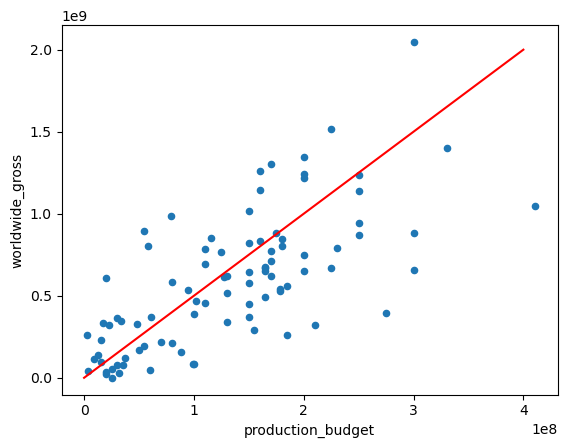

In [80]:
df1_and_2 = df_2.loc[df_2['movie'].isin(df1_top_movies['title'])]
df1_and_2.plot.scatter('production_budget', 'worldwide_gross')
plt.plot([0,400000000], [0,2000000000] ,color = 'red')

<AxesSubplot:xlabel='production_budget', ylabel='prod_world_ratio'>

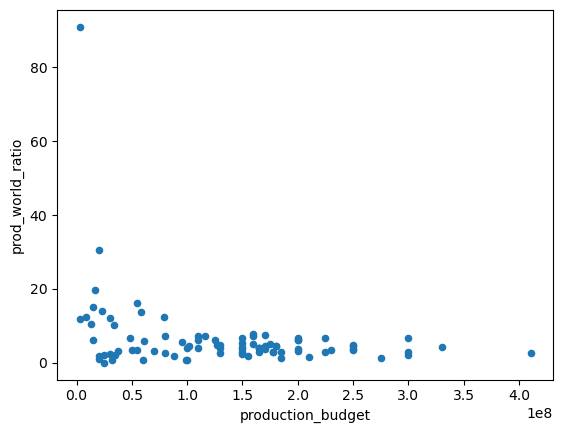

In [82]:
df1_and_2.plot.scatter('production_budget', 'prod_world_ratio')